# Apples detection using Faster R-CNN


This notebook describes in detail the *apple detection* process refered in our paper _**A methodology for detection and location of fruits in apples orchards from aerial images**_ (Santos & Gebler, SBIAgro 2021), see Section 2.1.1 in the paper.

In [1]:
import json
import numpy as np
import os
import random

from skimage import draw
from skimage import io as skio

import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

We have employed PyTorch 1.9.0 over CUDA 11.1. 

In [2]:
torch.__version__

'1.9.0+cu111'

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# The Dataset

This variable should point to your local copy of our *Apple From Drones Detection Dataset* (ADD):

In [4]:
DATASET_PATH = '../../../data/add256'
TRAIN_JSON_PATH = '../../../data/add256/training.json'
IMAGE_ROOT_PATH = '../../../data/add256/images'

In [5]:
class AppleFromDronesDetectionDataset(Dataset):

    def __init__(self, json_file, image_dir , transform=None, image_size=256):
        """
        Args:
            json_file (string): Path to the JSON file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional data augmentation to be applied
                on a sample.
        """

        self.images_dir = image_dir
        
        with open(json_file, 'r') as fp:
            json_str = ''.join(fp.readlines())

        self.annotations = json.loads(json_str)
        self.image_list = list(self.annotations.keys())        
        self.transform = transform
        self.boxes = list()
        
        for image_name in self.image_list:
            annot = self.annotations[image_name]
            boxes = list()
            for apple in annot:
                cx, cy, r = apple['cx'], apple['cy'], apple['r']
                x0, x1 = max(cx - r, 0), min(cx + r, image_size-1)
                y0, y1 = max(cy - r, 0), min(cy + r, image_size-1)
                boxes.append((x0, y0, x1, y1))
                
            self.boxes.append(np.array(boxes))
            
        self._num_apples = None
        

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        
        image_id = f'{idx:05d}:{self.image_list[idx]}'
        image_path = os.path.join(self.images_dir, self.image_list[idx])
        image = skio.imread(image_path)
        boxes = self.boxes[idx]
        n_boxes = boxes.shape[0]

        if self.transform:
            # Albumentations can transform images and boxes
            transformed = self.transform(image=image, 
                                         bboxes=boxes, 
                                         labels=[1] * n_boxes) 
            image = transformed["image"]
            boxes = transformed["bboxes"]

        labels =torch.ones((n_boxes, ), dtype=torch.int64)
        
        if n_boxes > 0:
            boxes = torch.stack([torch.tensor(box, dtype=torch.float16) for box in boxes])
        else:
            boxes = torch.zeros((0,4), dtype=torch.float16)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id
        }
            
        return image, target, image_id
    
    def num_apples(self):
        if self._num_apples is not None:
            return self._num_apples
        
        acc = 0
        for boxes in self.boxes:
            acc += boxes.shape[0]
            
        self._num_apples = acc
        return self._num_apples    

In [6]:
train_dataset = AppleFromDronesDetectionDataset(TRAIN_JSON_PATH, IMAGE_ROOT_PATH)

## Sanity check

In [7]:
n_train = len(train_dataset)
n_train

1025

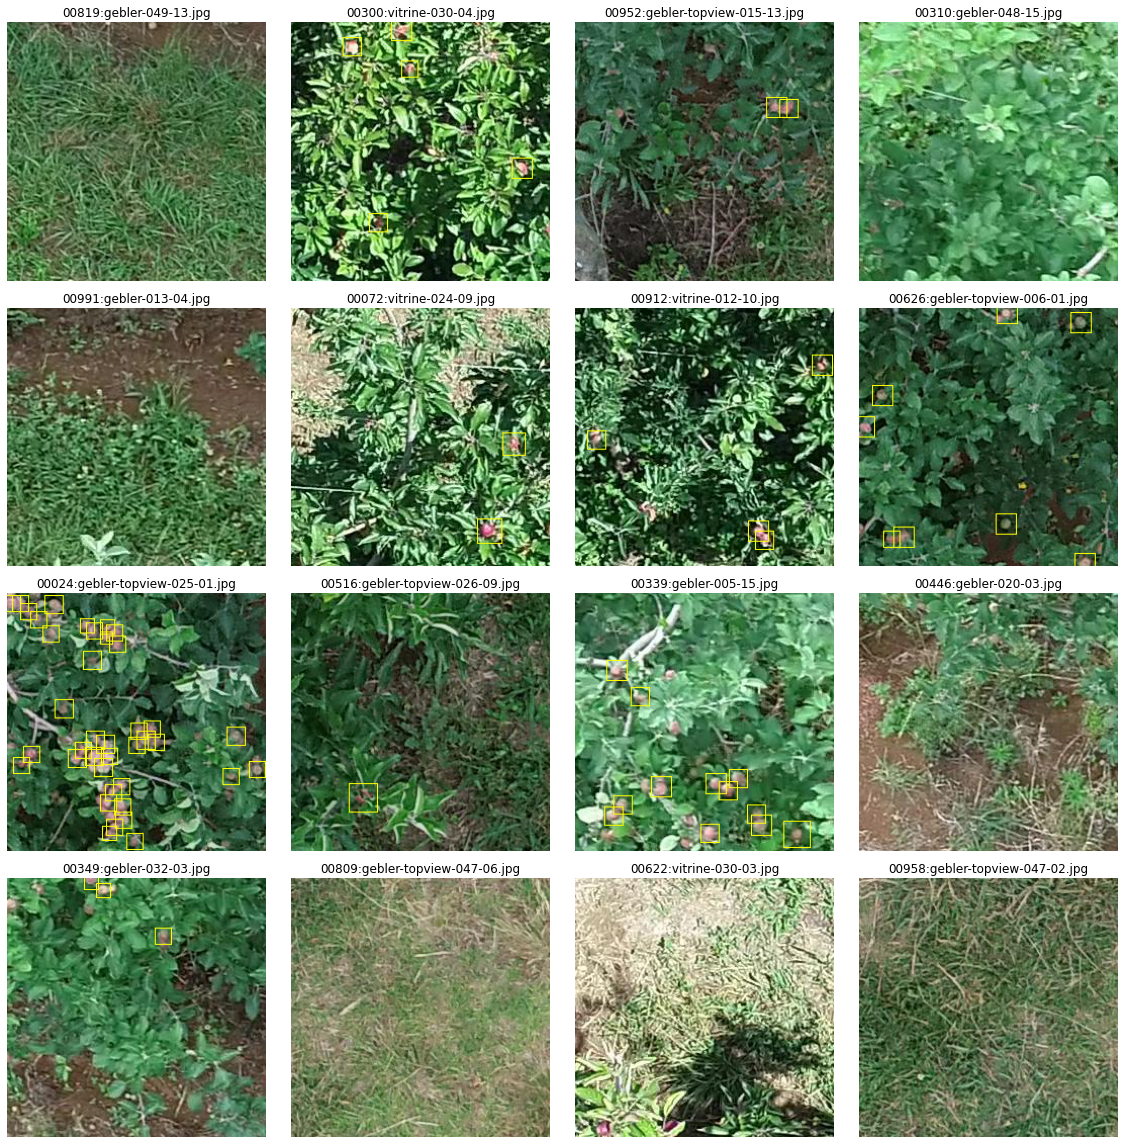

In [8]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=4, ncols=4)
axs = axs.reshape(-1)
YELLOW = (255, 255, 0)

for (img, target, img_id), ax in zip(random.choices(train_dataset, k=16), axs):
    
    display_img = img.copy()
    for (x0, y0, x1, y1) in target['boxes']:
        rr, cc = draw.rectangle_perimeter(start=(y0, x0), end=(y1, x1), shape=img.shape)
        display_img[rr, cc] = YELLOW
    
    ax.imshow(display_img)
    ax.set_title(img_id)
    ax.axis('off')
    
fig.tight_layout()

## The Dataloader

### Transformations

We employed the [Albumentations library](https://albumentations.ai/) for data augmentation:

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

Remember: `ToTensorV2` convert from NumPy `HWC` image is converted to PyTorch `CHW` tensor. If the image is in `HW` format (grayscale image), it will be converted to PyTorch `HW` tensor.

In [10]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(p=0.2),
    A.ColorJitter(p=0.2),
    A.Blur(p=0.2),
    A.RandomFog(p=0.2),
    ToTensorV2(),
],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['class_labels']
    )
)

#### Transforms sanity checking

In [11]:
aug_train_dataset = AppleFromDronesDetectionDataset(TRAIN_JSON_PATH, IMAGE_ROOT_PATH, transform=transform)

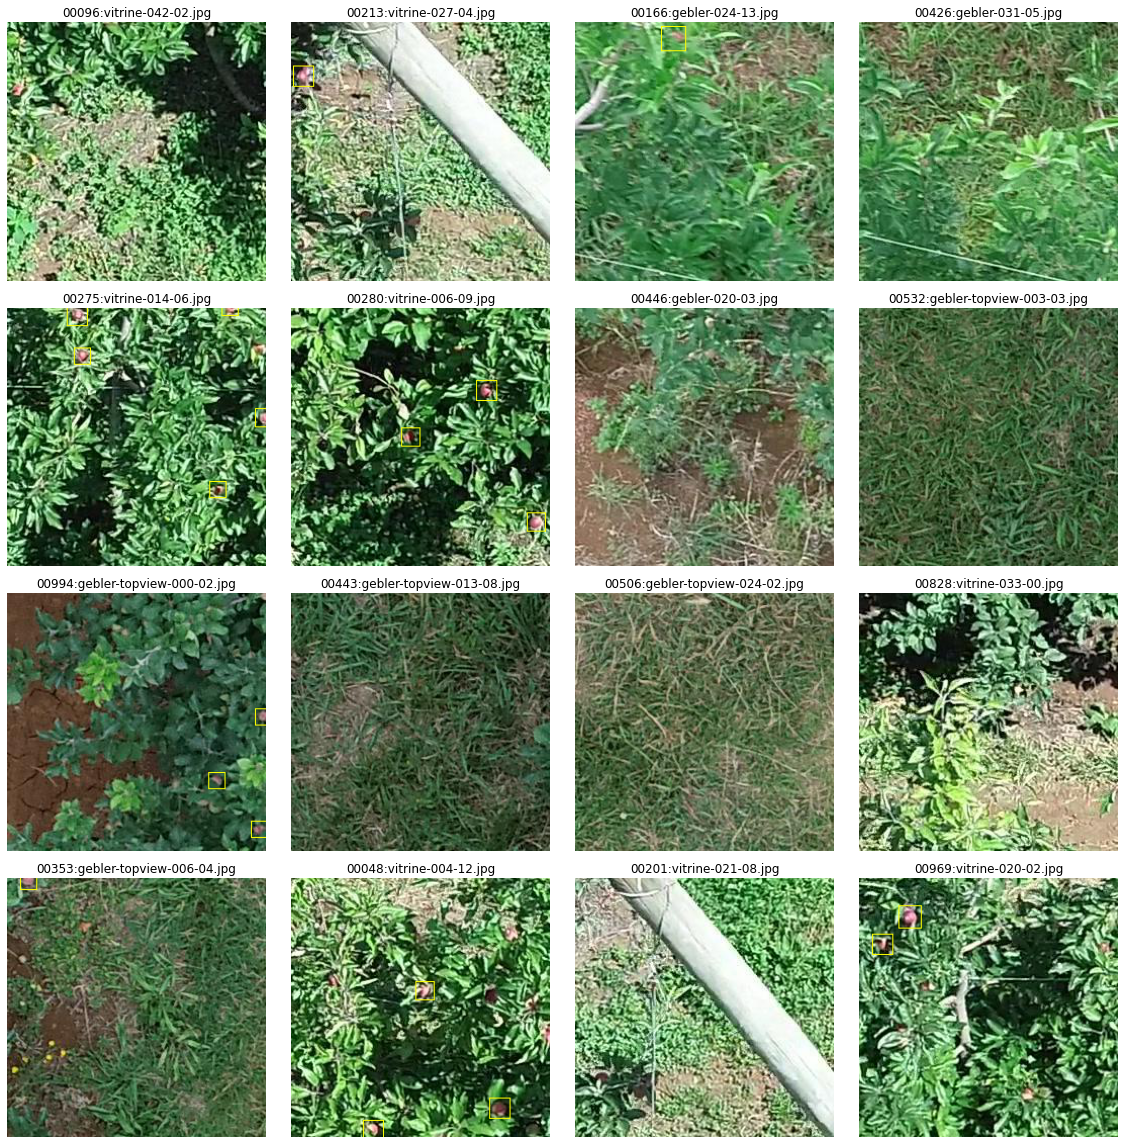

In [12]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=4, ncols=4)
axs = axs.reshape(-1)
YELLOW = (255, 255, 0)

for (img, target, img_id), ax in zip(random.choices(train_dataset, k=16), axs):
    
    n_boxes = len(target['boxes'])
    boxes = target['boxes']
    
    vis_img = img.copy()
    
    for x0, y0, x1, y1 in target['boxes'].numpy():
        rr, cc = draw.rectangle_perimeter((int(y0), int(x0)), end=(int(y1), int(x1)), shape=vis_img.shape)
        vis_img[rr, cc] = YELLOW
        
    ax.imshow(vis_img)
    ax.set_title(img_id)
    ax.axis('off')
    
fig.tight_layout()

Augmentations look fine, let's add normalization:

In [13]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(p=0.2),
    A.ColorJitter(p=0.2),
    A.Blur(p=0.2),
    A.RandomFog(p=0.2),
    A.Normalize(),
    ToTensorV2(),
],
    # The pascal_voc format is [x_min, y_min, x_max, y_max]
    bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels']
    )
)

In [14]:
def collate_fn(batch):
    images = [i for i, t, m in batch]
    targets = [t for i, t, m in batch]
    metadatas = [m for i, t, m in batch]
        
    return images, targets, metadatas

# Model  and Configuration

Using [PyTorch Lightning](https://www.pytorchlightning.ai):

In [15]:
import pytorch_lightning as pl

In [16]:
SEED = 42
pl.seed_everything(SEED)

Global seed set to 42


42

In [17]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

We are also employing version 0.10.0 of [torchvision](https://pytorch.org/vision/stable/index.html):

In [18]:
torchvision.__version__

'0.10.0+cu111'

## Configuration

In [19]:
conf = {
    'model_name': 'fasterrcnn_resnet50_fpn',
    'lr': 0.0001,
    'num_epochs': 160,
    'val_interval': 25,
    'train_batch_size': 6,
    'val_batch_size': 4
}

## Dataloaders

In [20]:
train_dataset = AppleFromDronesDetectionDataset(TRAIN_JSON_PATH, 
                                                IMAGE_ROOT_PATH,
                                                transform=transform)

train_size = int(len(train_dataset) * 0.9)
val_size = len(train_dataset) - train_size

# We sample 10% of the images as a validation dataset
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=conf['train_batch_size'],
                                          num_workers=8,
                                          pin_memory=True,
                                          shuffle=False,                                        
                                          collate_fn=collate_fn)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                          batch_size=conf['val_batch_size'],
                                          num_workers=8,
                                          pin_memory=True,
                                          shuffle=False,
                                          collate_fn=collate_fn)

Sanity check for the data loader:

In [21]:
batch = next(iter(train_dataloader))
images, targets, ids = batch

for i in [0, 2, 3]:
    print(ids[i])
    print(images[i].shape, images[i].dtype)
    print(targets[i])

00492:gebler-011-11.jpg
torch.Size([3, 256, 256]) torch.float32
{'boxes': tensor([[ 31., 149.,  53., 171.]], dtype=torch.float16), 'labels': tensor([1]), 'image_id': '00492:gebler-011-11.jpg'}
00792:vitrine-019-07.jpg
torch.Size([3, 256, 256]) torch.float32
{'boxes': tensor([], size=(0, 4), dtype=torch.float16), 'labels': tensor([], dtype=torch.int64), 'image_id': '00792:vitrine-019-07.jpg'}
00925:vitrine-013-11.jpg
torch.Size([3, 256, 256]) torch.float32
{'boxes': tensor([], size=(0, 4), dtype=torch.float16), 'labels': tensor([], dtype=torch.int64), 'image_id': '00925:vitrine-013-11.jpg'}


## Trainning system and model

### Object detection accuracy

In [22]:
from torchmetrics import Metric

from torchvision.models.detection._utils import Matcher
from torchvision.ops.boxes import box_iou

In [23]:
def bounding_box_filtering(boxes, scores, nms_iou=0.4, min_score=0.4):
    if len(boxes) == 0:
        # Nothing to filter
        return boxes
    
    nms = torchvision.ops.nms(boxes, scores, nms_iou)
    nms = nms[scores[nms] > min_score]
    
    return boxes[nms]

In [24]:
class ObjDetectionAccuracy(Metric):
    def __init__(self, dist_sync_on_step=False, iou_threshold=0.4, min_score=0.5):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        self.iou_threshold = iou_threshold
        self.min_score = min_score
        
        self.add_state("true_positive", 
                       default=torch.tensor(0), 
                       dist_reduce_fx="sum")
        self.add_state("false_positive", 
                       default=torch.tensor(0), 
                       dist_reduce_fx="sum")
        self.add_state("false_negative", 
                       default=torch.tensor(0), 
                       dist_reduce_fx="sum")
        self.add_state("ground_truth", 
                       default=torch.tensor(0), 
                       dist_reduce_fx="sum")

    def update(self, batch_preds_boxes, batch_targets_boxes):
        
        # Iterate batch
        for pred, y in zip(batch_preds_boxes, batch_targets_boxes):
            true_boxes = y['boxes']
            pred_boxes = bounding_box_filtering(pred['boxes'], 
                                                pred['scores'], 
                                                nms_iou=self.iou_threshold, 
                                                min_score=self.min_score)
        
            n_boxes_gt = len(true_boxes)
            n_boxes_pred = len(pred_boxes)
            
            if n_boxes_gt == 0:
                tp = 0
                fn = 0
                if n_boxes_pred == 0:
                    fp = 0
                else:
                    # No true boxes but the pred report something
                    fp = n_boxes_pred
            else:
                if n_boxes_pred == 0:
                    # No true positive or false positive - every target is a false negative
                    tp, fp = 0, 0
                    fn = n_boxes_pred
                else:
                    # There are true boxes AND reported boxes - so we need matching:
                    matcher = Matcher(high_threshold=self.iou_threshold, 
                                      low_threshold=0.0, 
                                      allow_low_quality_matches=False)
                    quality_matrix = box_iou(true_boxes, pred_boxes)
                    matching = matcher(quality_matrix)
                    fp = (matching < 0).count_nonzero().item()
                    tp = (matching >= 0).count_nonzero().item()
                    fn = len([i for i in range(n_boxes_gt) if i not in matching])

        self.false_positive += torch.tensor(fp)
        self.true_positive += torch.tensor(tp)
        self.false_negative += torch.tensor(fn)
        self.ground_truth += torch.tensor(n_boxes_gt)

    def compute(self):
        
        total = self.true_positive.float() + self.false_positive.float() + self.false_negative.float()
        return self.true_positive.float() / total

In [25]:
from torchvision.utils import draw_bounding_boxes

In [26]:
# Default Albumentations normalization parameters (mean, std)

def denormalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pix_val=255):
    ten = x.clone()
    for t, m, s in zip(ten, mean, std):
        t.mul_(s * max_pix_val).add_(m * max_pix_val)
        
    return torch.clamp(ten, 0, max_pix_val)

The code below will provide visualizations for the batches at the end of each validation step (the procedure will be called by `validation_epoch_end` in Lightning):

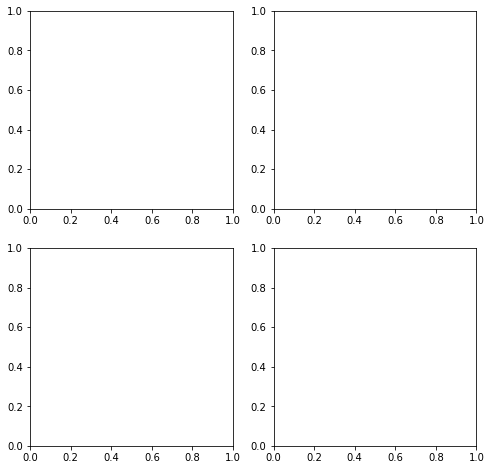

In [27]:
fig, axs = plt.subplots(figsize=(8, 8), nrows=2, ncols=2, num=0)
axs = axs.reshape(-1)

def save_visualization_for_batch(images, preds, targets):
      
    YELLOW = (192, 192, 0)
    BLUE = (0, 0, 192)

    for ax, img, pred, y in zip(axs, images, preds, targets):
        
        # Get a (denormalized) copy of the image
        vis_img = denormalize(img).cpu().to(dtype=torch.uint8)
        
        # Draw targets
        n_boxes = y['boxes'].shape[0]
        vis_img = draw_bounding_boxes(vis_img, y['boxes'], colors=n_boxes * [YELLOW], width=2)
        
        # Filter pred
        scores = pred['scores']
        # pboxes = bounding_box_filtering(pred['boxes'], scores, nms_iou=0.4, min_score=0.4)
        pboxes = pred['boxes']

        # Draw (filtered) predictions
        n_boxes = pboxes.shape[0]
        vis_img = draw_bounding_boxes(vis_img, pboxes, colors=n_boxes * [BLUE], width=1)

        ax.imshow(np.moveaxis(vis_img.numpy(), 0, -1))
        ax.axis('off')

    fig.tight_layout()
    fig.savefig('./val_sample.png')

In [28]:
class LitFasterRCNNAppleDetector(pl.LightningModule):

    def __init__(self, conf, pretrained=True):
        super().__init__()
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
        self.lr = conf['lr']
        self.val_accuracy = ObjDetectionAccuracy()

    
    def forward(self, images):
        # In Lightning, forward defines actions for inference-time
        return self.model(images)

    
    def training_step(self, batch, batch_idx):
        # In Lightning, training_step defines actions for a single batch trainining loop.
        # It is independent of forward
        images, targets, ids = batch
                
        # The model returns a Dict[Tensor] during training, containing 
        # the classification and regression losses for both the RPN and the R-CNN.
        loss_dict = self.model(images, targets)
        for loss_key, loss_val in loss_dict.items():
            self.log(loss_key, loss_val)
        
        train_loss = sum(loss for loss in loss_dict.values())
        self.log('train_loss', train_loss)
        
        return train_loss  
        
    def validation_step(self, batch, batch_idx):
        images, batch_targets, batch_ids = batch
        batch_preds = self.forward(images)
        
        self.val_accuracy(batch_preds, batch_targets)
        
        # If on_epoch is True, the logger automatically logs the end of epoch metric value 
        # by calling .compute().
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True)
        
        return images, batch_preds, batch_targets
    
    def validation_epoch_end(self, outputs):
        
        # See the last batch
        images, preds, targets = outputs[0]
        save_visualization_for_batch(images, preds, targets)              
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        return optimizer

# Training

In [29]:
logger = pl.loggers.TensorBoardLogger("tensorboard_logs", name=conf['model_name'])

In [30]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [31]:
model_name = conf['model_name']

checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='./checkpoints/',
    filename=model_name + '-{epoch:03d}-{val_acc:.2f}',
    save_top_k=3,
    mode='max',
)

/home/m351534/p-frutifut/ws/venv-pytorch1.9.0/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory ./checkpoints/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [32]:
trainer = pl.Trainer(gpus=1,
                     #auto_lr_find=True,
                     accumulate_grad_batches=4,
                     progress_bar_refresh_rate=1, 
                     max_epochs=conf['num_epochs'], 
                     deterministic=False,
                     logger=logger,
                     val_check_interval=conf['val_interval'],
                     callbacks=[checkpoint_callback]
                    )
model = LitFasterRCNNAppleDetector(conf)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


You can employ Lightning's *learning rate finder* to get a good initialization for the learning rate. We have found **0.0001** as a good starting point.

In [33]:
# lr_finder = trainer.tuner.lr_find(model, train_dataloader)
# lr_finder.plot(suggest=True)

In [34]:
model.lr

0.0001

In [35]:
foo

NameError: name 'foo' is not defined

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
model.freeze()

# See results on test set

In [38]:
bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])

totensor_transform = A.Compose([ToTensorV2()], bbox_params=bbox_params)
norm_totensor_transform = A.Compose([A.Normalize(), ToTensorV2()], bbox_params=bbox_params)

In [39]:
test_dataset_input = AppleFromDronesDetectionDataset('../../../data/add256/test.json', 
                                                IMAGE_ROOT_PATH,
                                                transform=norm_totensor_transform)

test_dataset_vis = AppleFromDronesDetectionDataset('../../../data/add256/test.json', 
                                                IMAGE_ROOT_PATH,
                                                transform=totensor_transform)

Below, predictions in *blue*, ground-truth in *yellow*:

/home/m351534/p-frutifut/ws/venv-pytorch1.9.0/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


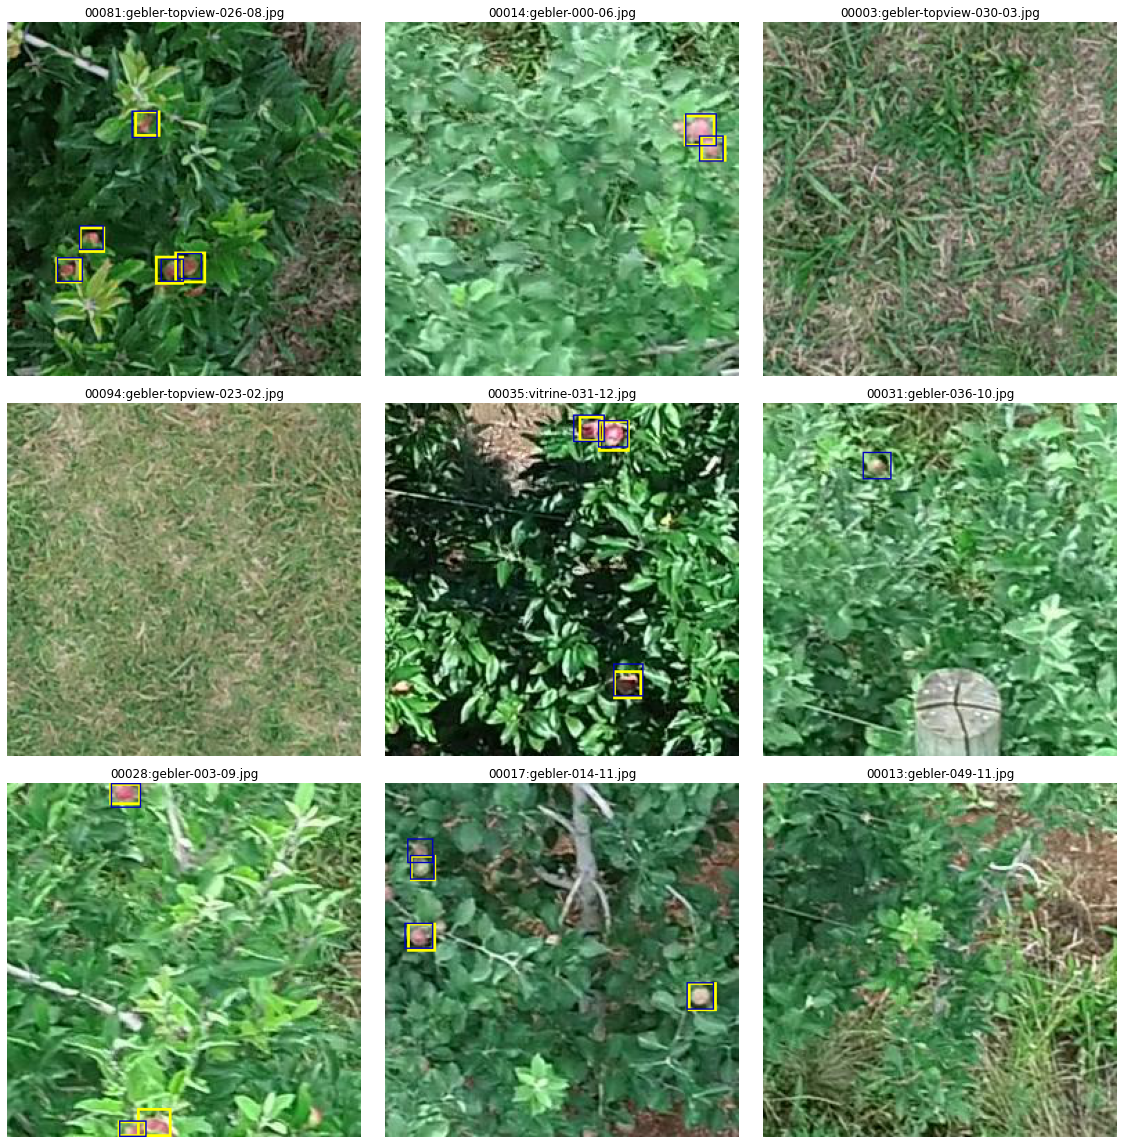

In [40]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=3, ncols=3)
axs = axs.reshape(-1)

BLUE = (0, 0, 192)

sample = random.sample(range(len(test_dataset_input)), k=9)

for idx, ax in zip(sample, axs):
    
    # Vis dataset returns non-normalized Torch tensors
    vis_img, target, vis_img_id = test_dataset_vis[idx]  
    
    # Input dataset returns Torch tensors (images are normalized), as expected by the model
    input_img, __, in_img_id = test_dataset_input[idx]
    
    assert(vis_img_id == in_img_id)
    
    n_boxes = target['boxes'].shape[0]
    vis_img = draw_bounding_boxes(vis_img, target['boxes'], colors=n_boxes * [YELLOW], width=2)
    
    pred = model(input_img.unsqueeze(dim=0))
    scores = pred[0]['scores']
    pboxes = bounding_box_filtering(pred[0]['boxes'], scores, nms_iou=0.4, min_score=0.04)

    n_boxes = pboxes.shape[0]
    vis_img = draw_bounding_boxes(vis_img, pboxes, colors=n_boxes * [BLUE], width=1)
        
    ax.imshow(np.moveaxis(vis_img.numpy(), 0, -1))
    ax.set_title(vis_img_id)
    ax.axis('off')
    
fig.tight_layout()
fig.savefig('./test-detection-sample.png')

## Saving the model

In [36]:
filename = model_name + '-final.pth'
filename

'fasterrcnn_resnet50_fpn-final.pth'

In [ ]:
torch.save(model.model.state_dict(), os.path.join('./checkpoints', filename))

## Evaluate accuracy on test set

In [37]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load(os.path.join('./checkpoints', filename)))
model.train(False)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [41]:
len(test_dataset_input)

114

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset_input,
                                              batch_size=conf['train_batch_size'],
                                              num_workers=8,
                                              pin_memory=True,
                                              shuffle=False,                                        
                                              collate_fn=collate_fn)

In [42]:
obj_accuracy = ObjDetectionAccuracy()

In [ ]:
for bi, (images, targets, ids) in enumerate(test_dataloader):
    
    preds = model(images)
       
    preds = model(images)
    obj_accuracy.update(preds, targets)
    gt = obj_accuracy.ground_truth.tolist()
    fn = obj_accuracy.false_negative.tolist()
    fp = obj_accuracy.false_positive.tolist()
    tp = obj_accuracy.true_positive.tolist()
    print(f"Batch #{bi}")
    print(f"Accumulated: Ground-truth: {gt}\tFalse negatives: {fn}\tFalse positives: {fp}\tTrue positives: {tp}")

In [ ]:
obj_accuracy.compute()

In [43]:
images, targets, metadatas = collate_fn(test_dataset_input)

In [63]:
obj_accuracy = ObjDetectionAccuracy()
preds = list()

for i, img in enumerate(images):
    print(f"Test image #{i}")
    preds = model([img])
    obj_accuracy.update(preds, [targets[i]])
    
    gt = obj_accuracy.ground_truth.tolist()
    fn = obj_accuracy.false_negative.tolist()
    fp = obj_accuracy.false_positive.tolist()
    tp = obj_accuracy.true_positive.tolist()

    print(f"Accumulated: Ground-truth: {gt}\tFalse negatives: {fn}\tFalse positives: {fp}\tTrue positives: {tp}")

Test image #0
Accumulated: Ground-truth: 0	False negatives: 0	False positives: 0	True positives: 0
Test image #1
Accumulated: Ground-truth: 4	False negatives: 0	False positives: 0	True positives: 4
Test image #2
Accumulated: Ground-truth: 9	False negatives: 2	False positives: 1	True positives: 7
Test image #3
Accumulated: Ground-truth: 9	False negatives: 2	False positives: 1	True positives: 7
Test image #4
Accumulated: Ground-truth: 9	False negatives: 2	False positives: 1	True positives: 7
Test image #5
Accumulated: Ground-truth: 9	False negatives: 2	False positives: 1	True positives: 7
Test image #6
Accumulated: Ground-truth: 10	False negatives: 2	False positives: 1	True positives: 8
Test image #7
Accumulated: Ground-truth: 10	False negatives: 2	False positives: 1	True positives: 8
Test image #8
Accumulated: Ground-truth: 11	False negatives: 2	False positives: 1	True positives: 9
Test image #9
Accumulated: Ground-truth: 14	False negatives: 4	False positives: 1	True positives: 10
Test 

Accumulated: Ground-truth: 181	False negatives: 42	False positives: 16	True positives: 132
Test image #81
Accumulated: Ground-truth: 186	False negatives: 43	False positives: 16	True positives: 136
Test image #82
Accumulated: Ground-truth: 189	False negatives: 45	False positives: 16	True positives: 137
Test image #83
Accumulated: Ground-truth: 190	False negatives: 45	False positives: 16	True positives: 138
Test image #84
Accumulated: Ground-truth: 191	False negatives: 45	False positives: 16	True positives: 139
Test image #85
Accumulated: Ground-truth: 191	False negatives: 45	False positives: 17	True positives: 139
Test image #86
Accumulated: Ground-truth: 193	False negatives: 45	False positives: 17	True positives: 141
Test image #87
Accumulated: Ground-truth: 195	False negatives: 45	False positives: 17	True positives: 143
Test image #88
Accumulated: Ground-truth: 195	False negatives: 45	False positives: 17	True positives: 143
Test image #89
Accumulated: Ground-truth: 195	False negatives

In [64]:
obj_accuracy.compute()

tensor(0.6944)